# Wrapping My Head Around LEISA data
_Ben Kamphaus, PhD_

FITS data can be a pain to work with, especially when it's data outside of your particular specialty (my background is remote sensing for sensors pointed at earth, not other planets), so this notebook shows some of the head-to-desk, brute force data wrangling involved in figuring out what's going on.

In [1]:
# our routine imports
import pyfits
import numpy as np
from matplotlib import pyplot as plt

In [2]:
!ls data/20070303_003520/

lsb_0035209319_0x53c_sci_1.fit	lsb_0035209319_0x53c_sci_1.lbl


In [7]:
fits_file = 'data/20070303_003520/lsb_0035209319_0x53c_sci_1.fit'
pyfits.info(fits_file)

Filename: data/20070303_003520/lsb_0035209319_0x53c_sci_1.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     285   (256, 256, 792)   float32   
1    WAVELENGTHS  ImageHDU         9   (256, 256, 2)   float32   
2    ANGLES      ImageHDU         9   (256, 256, 3)   float32   
3    FLATFIELD   ImageHDU         8   (256, 256)   float32   
4    CALIBRATION  ImageHDU         9   (256, 256, 2)   float32   
5    ERRORMAP    ImageHDU         8   (256, 256)   float32   
6    QUALITY     ImageHDU         8   (256, 256)   int16   
7    QUATERNIONS  ImageHDU        10   (5, 792)     float32   
8    HOUSEKEEPING  BinTableHDU    183   595R x 75C   [J, B, B, B, B, B, B, I, I, I, I, I, I, I, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, I, I, I, B, B, B, B, B, B, B, B, B, B, B, B, I, I, I, I, I, I, I, I, I, J, J, B, I, I, I, I, I, I, I, I, I, J]   


Ok, this time we've got an image cube.


In [10]:
data, hdr = pyfits.getdata(fits_file, 0, header=True)
hdr

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  256 / length of data axis 1                          
NAXIS2  =                  256 / length of data axis 2                          
NAXIS3  =                  792 / length of data axis 3                          
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                    0 / no offset                                      
BSCALE  =                    1 / default scaling factor                         
MISSION = 'New Horizons'       / Mission name                                   
HOSTNAME= 'NEW HORIZONS'    

In [11]:
np.shape(data)

(792, 256, 256)

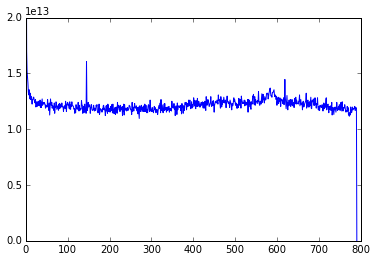

In [48]:
%matplotlib inline
plt.plot(np.ravel(data[:,100,100]))
plt.ylim((0,2e13))
plt.show()

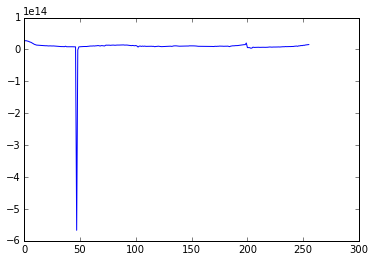

In [45]:
plt.plot(np.ravel(data[100,:,100]))
plt.show()

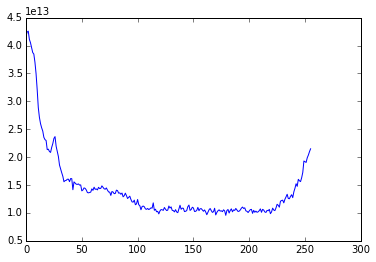

In [46]:
plt.plot(np.ravel(data[100,100,:]))

The [official spec](http://new-pds-rings-2.seti.org/newhorizons/SOC_INST_ICD.PDF) for the LEISA instrument says that pixels are BIL, using (X, Y, Z) as 256,256,N where X, Y, Z are wavelength, at X-offset, in the Nth frame. Since FITS files are created/written w/IDL, Fortran conventions (column major instead of row major) and numpy is (w/o changing args/using keywords) row major, I think the correct interpretation of this is frame, X-offset, wavelength.

This looks consistent with calibrated radiance-ish -- in that it looks biases in a black-body-ish way (except the extra radiance towards the higher wavelengths).

In [49]:
wls, wl_hdr = pyfits.getdata(fits_file, 1, header=True)
np.shape(wls)

(2, 256, 256)

In [61]:
# the first band of this is supposed to be center wavelengths, though I'm not sure about the ordering
# this does look like this direction (slice of index 1) encompasses a range of wavelengths.
wls[0, :, 0]

array([ 2.49448347,  2.48605704,  2.47762823,  2.46919775,  2.46076703,
        2.45233655,  2.44390774,  2.43548131,  2.42705822,  2.41863942,
        2.41022563,  2.40181828,  2.3934176 ,  2.38502479,  2.37664056,
        2.36826587,  2.35990143,  2.35154796,  2.34320641,  2.33487725,
        2.32656145,  2.31825972,  2.30997276,  2.30170107,  2.29344535,
        2.28520632,  2.27698469,  2.26878095,  2.2605958 ,  2.25242996,
        2.24428344,  2.23615742,  2.2280519 ,  2.21996784,  2.21190548,
        2.20386529,  2.19584775,  2.18785357,  2.17988276,  2.17193604,
        2.16401362,  2.15611625,  2.14824367,  2.14039683,  2.13257575,
        2.12478089,  2.11701226,  2.10927057,  2.10155582,  2.09386849,
        2.08620858,  2.07857633,  2.07097197,  2.06339598,  2.05584812,
        2.04832911,  2.04083848,  2.03337669,  2.02594399,  2.01854014,
        2.01116562,  2.00382042,  1.99650431,  1.98921776,  1.98196054,
        1.97473288,  1.96753478,  1.96036601,  1.95322692,  1.94

In [62]:
# and this one looks like slight variation in real wavelength center across pixels that
# should roughly be in the same wavelength range.
wls[0, 0, :]

array([ 2.49448347,  2.49452114,  2.49454188,  2.49454689,  2.49453759,
        2.49451518,  2.49448109,  2.49443603,  2.49438119,  2.49431753,
        2.49424577,  2.49416685,  2.4940815 ,  2.49399042,  2.4938941 ,
        2.49379349,  2.49368858,  2.49358034,  2.493469  ,  2.49335504,
        2.49323893,  2.49312067,  2.49300098,  2.49288011,  2.49275804,
        2.49263525,  2.49251175,  2.49238777,  2.49226379,  2.49213958,
        2.49201536,  2.49189115,  2.49176717,  2.49164367,  2.4915204 ,
        2.49139738,  2.49127507,  2.491153  ,  2.49103165,  2.49091077,
        2.49079037,  2.49067068,  2.49055147,  2.49043298,  2.49031472,
        2.49019742,  2.49008036,  2.48996401,  2.4898479 ,  2.48973274,
        2.48961782,  2.48950338,  2.48938942,  2.48927617,  2.48916316,
        2.48905063,  2.48893857,  2.48882723,  2.48871613,  2.4886055 ,
        2.48849535,  2.48838568,  2.48827672,  2.488168  ,  2.48806   ,
        2.48795223,  2.48784542,  2.48773885,  2.48763323,  2.48

In [54]:
wl_hdr

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  256 / length of data axis 1                          
NAXIS2  =                  256 / length of data axis 2                          
NAXIS3  =                    2 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'WAVELENGTHS'        / extension name                                 

FITS data can be so strange. You might think "-32" would be a signed 32-bit integer, but this is floating point.

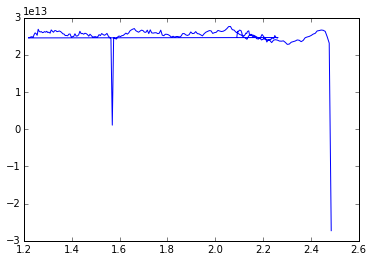

In [78]:
# ok, let's see if we can plot a spectrum. Ordering will probably be sort of strange
# based on what we've seen.
plt.plot(np.ravel(wls[0,:,100]), np.ravel(data[100,0,:]))

Ok, this is an ok candidate for a spectrum. There's something of a glitchy looking line of odd (false?) contiguity across wavelengths in the above plot, maybe correctable w/a sort, but this looks reasonable as a spectrum prior to the application of gains and offsets. The [spec](http://new-pds-rings-2.seti.org/newhorizons/SOC_INST_ICD.PDF) shows that we have a dataset in the FITS file of gains and offsets as well as a map of bad pixels that can be used as a mask. Lets look at applying these.

**Note**: I could still be completely wrong at this point.

In [73]:
gain_offset, go_hdr = pyfits.getdata(fits_file, 4, header=True)
(go_hdr, np.shape(gain_offset))

(XTENSION= 'IMAGE   '           / IMAGE extension                                
 BITPIX  =                  -32 / number of bits per data pixel                  
 NAXIS   =                    3 / number of data axes                            
 NAXIS1  =                  256 / length of data axis 1                          
 NAXIS2  =                  256 / length of data axis 2                          
 NAXIS3  =                    2 / length of data axis 3                          
 PCOUNT  =                    0 / required keyword; must = 0                     
 GCOUNT  =                    1 / required keyword; must = 1                     
 EXTNAME = 'CALIBRATION'        / extension name                                 ,
 (2, 256, 256))

The general strategy to apply gains and offsets is this basic equation:

rad_cal = gain \* DN + offset

It's fairly trivial to adapt this to Python

In [79]:
def cal(DN, gain, offset):
    return gain*DN + offset

In [80]:
# with operator overloading for ndarrays in numpy, we can apply this across the arrays.
cal_data = cal(data[0,:,:], gain_offset[0,:,:], gain_offset[1,:,:])

In [92]:
# really, though, we want to apply this to each frame. this is the kind of thing that's trivial
# to express w/a list of frames, harder w/an ND array. 
cal_all_data = np.zeros_like(data)
(np.shape(cal_all_data,), np.shape(data))

((792, 256, 256), (792, 256, 256))

In [114]:
# Populate cal_all_data image cube. We could probably replace this w/a vectorized operation,
# but this solves it and I don't have a perf requirement to optimize this -- yet.
for i in range(np.shape(cal_all_data)[0]):
    cal_all_data[i] = cal(data[i,:,:], gain_offset[1,:,:], gain_offset[0,:,:])

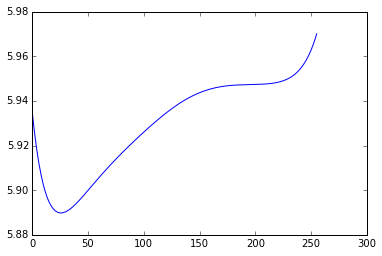

In [124]:
# ok this result looks really smooth, but doesn't have the features you'd expect
# for a spectrum (fine absorption and emissivity features)
plt.plot(cal_all_data[0,250,:])
plt.show()

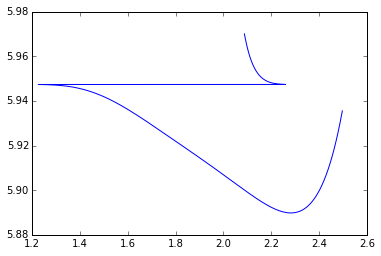

In [126]:
plt.plot(wls[0,:,250], cal_all_data[0,250,:])

I can't really determine anything from this. I want the wavelengths in order. This is
where `numpy.argsort` comes in - it returns indices we can use to sort multiple arrays.

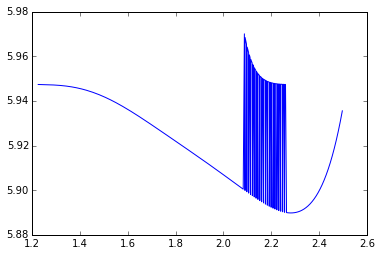

In [130]:
sort_i = np.argsort(np.ravel(wls[0,:,250]))
plt.plot(wls[0,sort_i,250], cal_all_data[0,250,sort_i])

In retrospect, the outcome of the sort should have been fairly obvious.

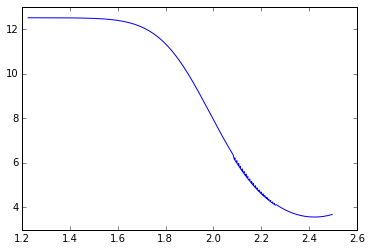

In [135]:
# ok, so my earlier assumption was wrong. Shouldn't draw conclusions from uncalibrated data!
# this matching calibration looks ok, but I'm not really sure what I'm looking at (other than
# that it looks like an inverted sigmoid).
plt.plot(wls[0,sort_i,250], cal_all_data[0,sort_i,5])
plt.show()

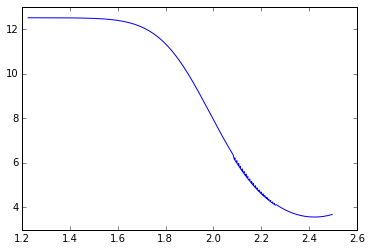

In [137]:
plt.plot(wls[0,sort_i,250], cal_all_data[100,sort_i,5])
plt.show()

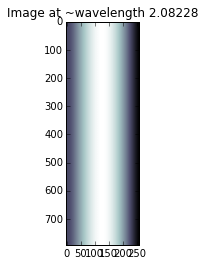

In [146]:
plt.imshow(cal_all_data[:,50,:], cmap='bone')
plt.title("Image at ~wavelength " + str(np.mean(wls[0,50,:])))
plt.show()

I think this may be the image portion, but I'm pretty out of my depth here and I think I need a new strategy. Let me summarize the outcome of this session:

* I was apply to apply gains and offsets in a way that looks correct, due to the smoothness of the outcome.
* I was able to determine where the spectral information was (in retrospect, this matches the BIL description, but not the ordering of the spec - which I'm probably reading incorrectly).
* I believe I can display images at wavelengths, but as I'm not completely certain what I'm looking at, it's difficult to verify. A roughness of fit w/my Geo vs. Astro background.

This is point where I think it's worth calling it quits and looking to match to a dataset with a published image or something where I can match a specific outcome, then return to more "play" with the data.